In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns


## Import data

In [30]:
# Load required csv files
path = r'Database/'
dfs = []
n = 0
print('Tables in Olist database:')
for files in os.listdir(path):
    if re.search(r'olist_.*\.csv',files):
        print('#',n,': ',files)
        n+=1
        dfs.append(pd.read_csv(path+files))

name_translation = pd.read_csv('Database/product_category_name_translation.csv')


Tables in Olist database:
# 0 :  olist_customers_dataset.csv
# 1 :  olist_geolocation_dataset.csv
# 2 :  olist_orders_dataset.csv
# 3 :  olist_order_items_dataset.csv
# 4 :  olist_order_payments_dataset.csv
# 5 :  olist_order_reviews_dataset.csv
# 6 :  olist_products_dataset.csv
# 7 :  olist_sellers_dataset.csv


In [31]:
# Merge desired columns

# Orders + reviews
clean_df = dfs[2].merge(dfs[5][['order_id','review_score']], left_on = 'order_id', right_on= 'order_id', how='left')

# order items dataset
clean_df = clean_df.merge(dfs[3][['order_id','product_id','seller_id','freight_value','price']], left_on = 'order_id', right_on = 'order_id', how='left')

# products dataset
clean_df = clean_df.merge(dfs[6][['product_id','product_category_name','product_photos_qty','product_description_lenght']], left_on = 'product_id', right_on = 'product_id', how='left')

# sellers dataset
clean_df = clean_df.merge(dfs[7][['seller_id','seller_state']], left_on = 'seller_id', right_on = 'seller_id', how='left')

# Category name translations and drop portuguese names
clean_df = clean_df.merge(name_translation, left_on = 'product_category_name', right_on = 'product_category_name', how = 'left')
clean_df.drop(columns='product_category_name', inplace = True)


In [32]:
# Clean merged dataset - parse data types and handle NaN
clean_df[['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']] = clean_df[['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']].apply(pd.to_datetime)
clean_df = clean_df[clean_df['order_status']=='delivered'].dropna()
clean_df['review_score'] = clean_df['review_score'].astype(int).astype(str)
#clean_df['seller_zip_code_prefix'] = clean_df['seller_zip_code_prefix'].astype(str)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108435 entries, 0 to 114091
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       108435 non-null  object        
 1   customer_id                    108435 non-null  object        
 2   order_status                   108435 non-null  object        
 3   order_purchase_timestamp       108435 non-null  datetime64[ns]
 4   order_approved_at              108435 non-null  datetime64[ns]
 5   order_delivered_carrier_date   108435 non-null  datetime64[ns]
 6   order_delivered_customer_date  108435 non-null  datetime64[ns]
 7   order_estimated_delivery_date  108435 non-null  datetime64[ns]
 8   review_score                   108435 non-null  object        
 9   product_id                     108435 non-null  object        
 10  seller_id                      108435 non-null  object        
 11  

In [33]:
# Release memory (delete original unmerged dataframes)
del dfs

In [34]:
# Feature engineering. Create and transform columns 
clean_df['days_order_to_customer'] = (clean_df['order_delivered_customer_date']-clean_df['order_purchase_timestamp']).dt.days
clean_df['days_order_to_approved'] = (clean_df['order_approved_at']-clean_df['order_purchase_timestamp']).dt.days
clean_df['days_order_to_carrier'] = (clean_df['order_delivered_carrier_date']-clean_df['order_purchase_timestamp']).dt.days
clean_df['days_order_to_estimated_delivery'] = (clean_df['order_estimated_delivery_date']-clean_df['order_purchase_timestamp']).dt.days

#Drop original date columns
clean_df.drop(columns=['order_delivered_customer_date','order_approved_at','order_delivered_carrier_date','order_estimated_delivery_date','order_purchase_timestamp'],inplace=True)

#Drop id columns
clean_df.drop(columns=['order_id','product_id','seller_id', 'customer_id', 'order_status'], inplace=True)

#Reorder columns


In [35]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108435 entries, 0 to 114091
Data columns (total 11 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   review_score                      108435 non-null  object 
 1   freight_value                     108435 non-null  float64
 2   price                             108435 non-null  float64
 3   product_photos_qty                108435 non-null  float64
 4   product_description_lenght        108435 non-null  float64
 5   seller_state                      108435 non-null  object 
 6   product_category_name_english     108435 non-null  object 
 7   days_order_to_customer            108435 non-null  int64  
 8   days_order_to_approved            108435 non-null  int64  
 9   days_order_to_carrier             108435 non-null  int64  
 10  days_order_to_estimated_delivery  108435 non-null  int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 9.9

In [36]:
clean_df.describe(include='all')

,review_score,freight_value,price,product_photos_qty,product_description_lenght,seller_state,product_category_name_english,days_order_to_customer,days_order_to_approved,days_order_to_carrier,days_order_to_estimated_delivery
count,108435,108435.000000,108435.000000,108435.000000,108435.00000,108435,108435,108435.000000,108435.000000,108435.000000,108435.000000
unique,5,NaN,NaN,NaN,NaN,22,71,NaN,NaN,NaN,NaN
top,5,NaN,NaN,NaN,NaN,SP,bed_bath_table,NaN,NaN,NaN,NaN
freq,62449,NaN,NaN,NaN,NaN,77336,10984,NaN,NaN,NaN,NaN
mean,NaN,19.967251,119.792305,2.208088,786.34914,NaN,NaN,11.965795,0.271388,2.784415,23.446655
std,NaN,15.700969,180.499347,1.719961,650.84363,NaN,NaN,9.350417,0.749775,3.625204,8.833060
min,NaN,0.000000,0.850000,1.000000,4.00000,NaN,NaN,0.000000,0.000000,-172.000000,2.000000
25%,NaN,13.080000,39.900000,1.000000,347.00000,NaN,NaN,6.000000,0.000000,1.000000,18.000000
50%,NaN,16.280000,74.900000,1.000000,601.00000,NaN,NaN,10.000000,0.000000,2.000000,23.000000
75%,NaN,21.150000,134.000000,3.000000,985.00000,NaN,NaN,15.000000,0.000000,4.000000,28.000000


## EDA

Text(0.5, 1.0, 'Linear correlation heatmap')

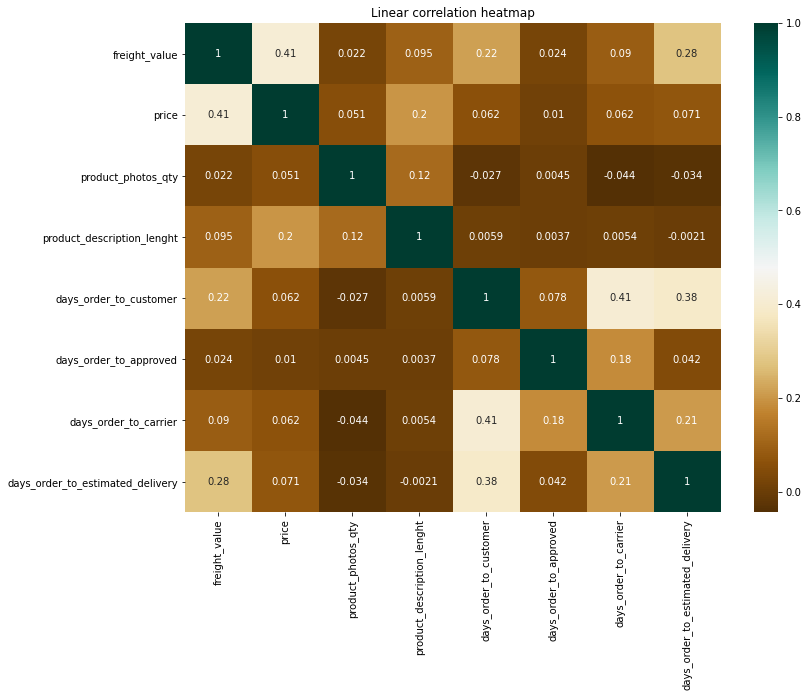

In [37]:
plt.figure(figsize=(12,9))
sns.heatmap(clean_df.corr(), annot=True, cmap='BrBG')
plt.title('Linear correlation heatmap')

Text(0.5, 1.0, 'Original review scores distribution - Imbalanced classes')

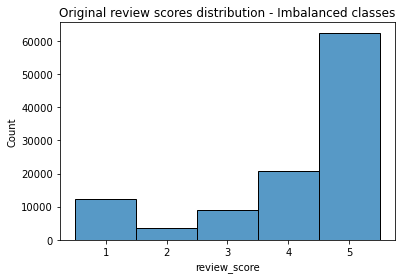

In [38]:
plt.figure(figsize=(6,4))
sns.histplot(clean_df.review_score.sort_values())
plt.title('Original review scores distribution - Imbalanced classes')

We can see the prediciton classes are very imbalanced. The values are also what we could expect from review scores, as people usually vote for either high or low vlaues.
Due to this, we decided to stratify as well as handle the imbalance by under/over sampling

## Model development

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from imblearn.over_sampling import RandomOverSampler 


### Bootstrap / Training and validation split / One hot encode

In [75]:
#Train test split
X = clean_df.drop(columns=['review_score'])
y = clean_df['review_score']

# One hot encode
X = pd.get_dummies(X)

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25, stratify=y)

# # Handle imbalanced set
oversample = RandomOverSampler(sampling_strategy='auto', random_state = 25) #Oversampling strategy
X_train, y_train = oversample.fit_resample(X, y)

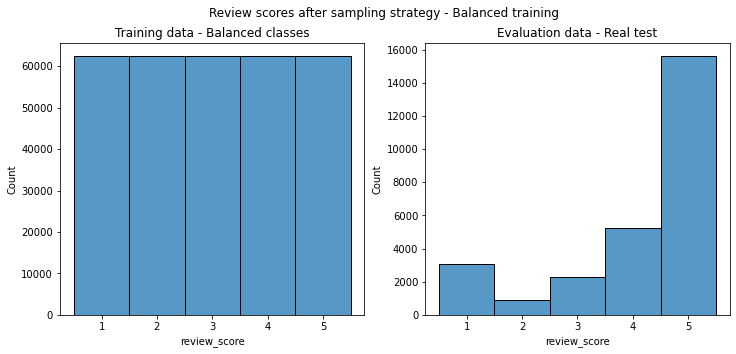

In [76]:
# Plot review scores after sampling strategy
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# plt.figure(figsize=(6,4))
sns.histplot(y_train.sort_values(), ax=ax1)
sns.histplot(y_test.sort_values(), ax=ax2)
plt.suptitle('Review scores after sampling strategy - Balanced training')
ax1.set_title('Training data - Balanced classes')
ax2.set_title('Evaluation data - Real test')

plt.show()

### Clustering - optimal size

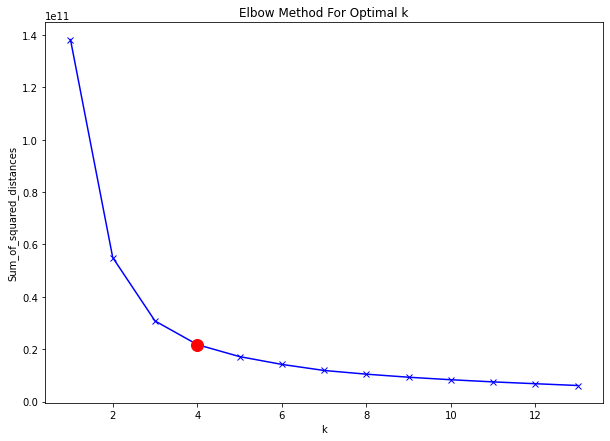

In [77]:
optimal_k = 4 #Change after analyzing graph

# Determine optimal cluster size by the elbow method
Sum_of_squared_distances = []
K = range(1,14)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_train)
    Sum_of_squared_distances.append(km.inertia_)

# Plot elbow method
plt.figure(figsize=(10,7))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.plot([optimal_k],[Sum_of_squared_distances[optimal_k-1]], 'ro',markersize=12)
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

We determined through the elbow method that k=4 was a good cluster size for this dataset

### Clustering - augmenting data

In [78]:
#### Get cluster labels for optimal cluster size
km = KMeans(n_clusters=optimal_k)
km.fit_transform(X_train)

# Add labels to dataset
X_train['cluster_cat'] = km.labels_
X_test['cluster_cat'] = km.predict(X_test)

# One hot encode
X_train = X_train.drop(columns=['cluster_cat']).join(pd.get_dummies(X_train['cluster_cat']))
X_test = X_test.drop(columns=['cluster_cat']).join(pd.get_dummies(X_test['cluster_cat']))


C:\Users\f2110\AppData\Local\Temp/ipykernel_22076/16101638.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['cluster_cat'] = km.predict(X_test)


### Model pipeline - preprocessing and fit

#### Random Forest

In [79]:
# Random Forest Classifier Pipeline

# Define scalers and model to train. Random Forest does not require scaling
RFR = RandomForestClassifier(n_estimators=100, verbose=1)

# Define numeric and categorical columns to apply different preprocessing
num_cols = X._get_numeric_data().columns
cat_cols = list(set(X.columns) - set(X._get_numeric_data().columns))

# Pipeline building
rf_pipe = make_pipeline(RFR)

#Fit model
rf_pipe.fit(X_train,y_train)

rf_y_pred = rf_pipe.predict(X_test)

print(rf_pipe.score(X_train, y_train))
print(rf_pipe.score(X_test,y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.6s finished


0.9968614389341702


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.9955365376812129


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished


#### Logistic Regression

In [80]:
# Logistic Regression Pipeline

# Define scalers and model to train
scaler = StandardScaler()
LR = LogisticRegression(max_iter=200, multi_class='multinomial')

# Define numeric and categorical columns to apply different preprocessing
num_cols = X._get_numeric_data().columns
cat_cols = list(set(X.columns) - set(X._get_numeric_data().columns))

# Transformer to apply transformations to categorical and numeric columns
transformer = ColumnTransformer([('num_cols', scaler, num_cols)])

# Pipeline building
rf_pipe = make_pipeline(transformer,LR)

#Fit model
rf_pipe.fit(X_train,y_train)

logReg_y_pred = rf_pipe.predict(X_test)

print(accuracy_score(y_train, rf_pipe.predict(X_train)))
print(accuracy_score(y_test, logReg_y_pred))


0.28038879725856297
0.39547751669187353


#### XGBoost

In [81]:
# XGBoost Pipeline

# Define scalers and model to train
scaler = StandardScaler()
XGBoost = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y.unique()), use_label_encoder=False)

# Define numeric and categorical columns to apply different preprocessing
num_cols = X._get_numeric_data().columns
cat_cols = list(set(X.columns) - set(X._get_numeric_data().columns))

# Transformer to apply transformations to categorical and numeric columns
transformer = ColumnTransformer([('num_cols', scaler, num_cols)])

# Pipeline building
rf_pipe = make_pipeline(transformer,XGBoost)

#Fit model
rf_pipe.fit(X_train,y_train.astype(int)-1)

xgboost_y_pred = rf_pipe.predict(X_test)

print(accuracy_score(y_train.astype(int)-1, rf_pipe.predict(X_train)))
print(accuracy_score(y_test.astype(int)-1, xgboost_y_pred))

xgboost_y_pred+=1
xgboost_y_pred = xgboost_y_pred.astype(str)

[01:48:34] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5240179986869286
0.5102733409568778


### Model evaluation

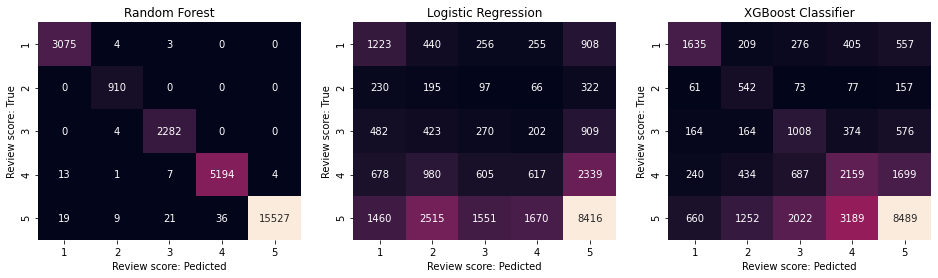

In [82]:
fig, ax = plt.subplots(1,3, figsize=(16,4))

sns.heatmap(confusion_matrix(y_test, rf_y_pred), annot=True, ax=ax[0], cbar=False, fmt="d")
ax[0].set_title('Random Forest')
ax[0].set_xlabel('Review score: Pedicted')
ax[0].set_ylabel('Review score: True')
ax[0].xaxis.set_ticklabels(['1', '2','3','4','5']); ax[0].yaxis.set_ticklabels(['1', '2','3','4','5'])

sns.heatmap(confusion_matrix(y_test, logReg_y_pred), annot=True, ax=ax[1], cbar=False, fmt="d")
ax[1].set_title('Logistic Regression')
ax[1].set_xlabel('Review score: Pedicted')
ax[1].set_ylabel('Review score: True')
ax[1].xaxis.set_ticklabels(['1', '2','3','4','5']); ax[1].yaxis.set_ticklabels(['1', '2','3','4','5'])

sns.heatmap(confusion_matrix(y_test, xgboost_y_pred), annot=True, ax=ax[2], cbar=False, fmt="d")
ax[2].set_title('XGBoost Classifier')
ax[2].set_xlabel('Review score: Pedicted')
ax[2].set_ylabel('Review score: True')
ax[2].xaxis.set_ticklabels(['1', '2','3','4','5']); ax[2].yaxis.set_ticklabels(['1', '2','3','4','5'])

# print accuracy and recall...

plt.show()

# Current steps taken:
__Note:__ I decided to treat problem as a classification problem since review scores were integers 1-5  
__Note 2:__ I believe seller location to be a good predictor. However, having city names and zip codes greatly increases columns which makes models slow/not converge. Maybe we could replace them with a single float column based on distance from zip code of seller and customer.
1. Merged desired columns.
2. Selected only orders marked as 'delivered'.
3. dropped all columns that contained any NaN.
4. EDA
5. feature engineering (see notebook section). Added mainly the date difference columns.
6. Over-sampled to get rid of the imbalanced dataset. Note: Random forest performs very well and all others very bad. Under sampling yields very bad performance for all. 
7. Stratified train test split.
8. Clustering (seems to not have an impact, could try creating a model for each cluster).
9. One hot encoded.
10. Trained: Random forest, logistic regression, XGBoost.

# Things to add:
0. Could try different feature engineering/using different columns from dataset (could add distance from seller to customer)
1. Improve EDA. (e.g. something that shows if seller location is a good predictor)
2. ROC AUC curves for classification models in model evaluation. It is important to determine if the model is classifying properly low and high scores.
3. Add table with summary of evaluation scores for each model
4. Feature selection: Implement one of the techniques in class for feature selection of the models
5. (optional) Test 1 or 2 more models for comparison. Naive Bayes? MultiLogit?
6. Cross validation model tuning. (GridSearchCV)
7. Add precission and recall, false positive and false negatives. The most important would be for review scores of 1 or 2, since these are the customers we want to avoid from complaining. _Recall = TP/(TP+FN) : Precision = TP/(TP+FP)_

## Objective proposal:  
Predict review score for each order.  
Once deployed, the model would predict the review score for each customer's order. If low, the company could issue a coupon/promotion/apology to the customer in order to prevent the bad review.